## 1. Introducción teórica

El Análisis de Componentes Principales (PCA) es una técnica estadística utilizada para reducir la dimensionalidad de un conjunto de datos manteniendo la mayor cantidad de información posible. En economía, es útil para sintetizar información de múltiples variables macroeconómicas en unos pocos factores o “componentes” que capturan los patrones comunes del sistema económico.

En esta clase aplicaremos PCA para extraer **factores latentes** a partir de variables económicas mensuales, y luego utilizaremos estos factores como insumos en un modelo de regresión para predecir el crecimiento del PIB.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Paso 2. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

## 3. Simulación de datos económicos

Simularemos 120 observaciones mensuales con las siguientes variables:
- Inflación
- Reservas internacionales
- Exportaciones e importaciones
- Crédito al sector privado
- Tipo de cambio
- Tasa de interés
- Índice de confianza

In [22]:
# cargar_y_limpiar_trimestral.py
# -----------------------------------------------
# Carga y limpieza de datos trimestrales para análisis económico
# -----------------------------------------------

import pandas as pd

# Definir ruta del archivo Excel
# ruta = r"C:\Users\IVAN JESUS ROMERO\Desktop\inv\CLASE 1\FK.xlsx"
ruta = "/content/drive/MyDrive/Econometria Analisis de Datos e IA en software/Modulo 2/Clases 1 y 2/FK.xlsx"

# Leer el archivo
xls = pd.ExcelFile(ruta)

# Mostrar nombres de hojas
print("Hojas disponibles:", xls.sheet_names)

# Leer hoja 'Trimestral'
df = pd.read_excel(xls, sheet_name="Trimestral")

# Mostrar valores nulos por columna (antes de limpieza)
print("\n Valores nulos antes de limpieza:")
print(df.isnull().sum())

# Paso 1: eliminar filas totalmente vacías
df = df.dropna(how="all")

# Paso 2: eliminar columnas con más del 50% de valores nulos
umbral = 0.5 * len(df)
df = df.loc[:, df.isnull().sum() < umbral]

# Paso 3: imputar valores faltantes con forward fill y backward fill
df = df.fillna(method='ffill').fillna(method='bfill')

# Mostrar resumen final
print("\n Datos después de limpieza:")
print(f"Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
print("\nPrimeras filas del DataFrame limpio:")
print(df.head())

Hojas disponibles: ['Trimestral', 'Anual']

 Valores nulos antes de limpieza:
fecha    1
pib      2
itcr     5
tc       0
inf      4
infe     4
dtype: int64

 Datos después de limpieza:
Filas: 140 | Columnas: 6

Primeras filas del DataFrame limpio:
       fecha           pib       itcr      tc       inf      infe
0 1990-03-01  3.587595e+06  89.805307  3.0703  0.244011  5.779607
1 1990-06-01  3.926068e+06  89.805307  3.1477  0.244011  5.779607
2 1990-09-01  3.934133e+06  89.805307  3.2410  0.244011  5.779607
3 1990-12-01  3.995340e+06  89.805307  3.3748  0.244011  5.779607
4 1991-03-01  3.677806e+06  89.805307  3.5019  0.244011  5.779607


In [23]:
df["pib_ia"] = df["pib"].pct_change(4) * 100
df["tc_ia"] = df["tc"].pct_change(4) * 100
print(df.head())

       fecha           pib       itcr      tc       inf      infe    pib_ia  \
0 1990-03-01  3.587595e+06  89.805307  3.0703  0.244011  5.779607       NaN   
1 1990-06-01  3.926068e+06  89.805307  3.1477  0.244011  5.779607       NaN   
2 1990-09-01  3.934133e+06  89.805307  3.2410  0.244011  5.779607       NaN   
3 1990-12-01  3.995340e+06  89.805307  3.3748  0.244011  5.779607       NaN   
4 1991-03-01  3.677806e+06  89.805307  3.5019  0.244011  5.779607  2.514512   

       tc_ia  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4  14.057258  


In [24]:
df.drop(columns=['pib', 'tc'], inplace=True)
df = df.dropna(subset=['pib_ia', 'tc_ia'])
print(df.head())

       fecha       itcr       inf      infe    pib_ia      tc_ia
4 1991-03-01  89.805307  0.244011  5.779607  2.514512  14.057258
5 1991-06-01  88.664188  0.233678  2.713131  7.435326  13.543222
6 1991-09-01  93.373602  0.212258  2.907812  5.476233  12.394323
7 1991-12-01  94.696616  0.145158  3.861125  5.399976  10.400616
8 1992-03-01  91.901012  0.130426  5.744869  3.207077   8.429710


## 4. Análisis exploratorio preliminar

Visualizamos la correlación entre variables para entender la necesidad de reducción de dimensionalidad.

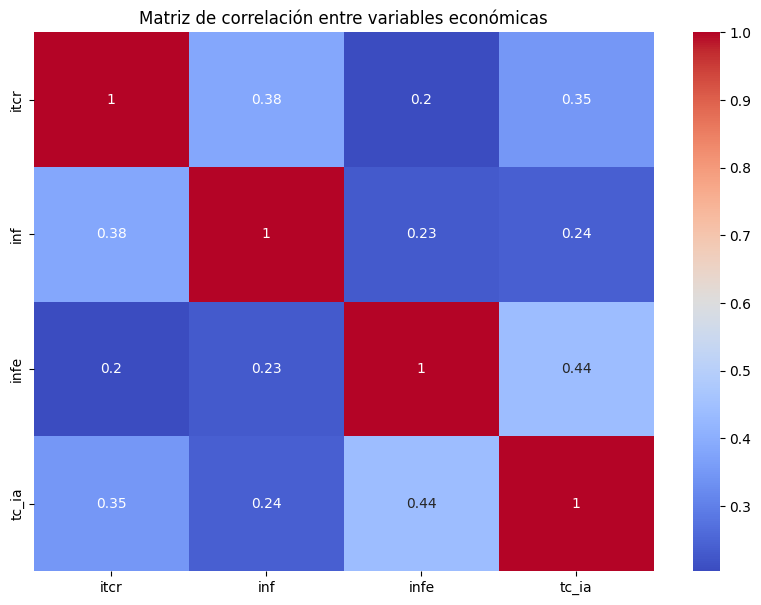

In [25]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.drop(columns=["fecha", "pib_ia"]).corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación entre variables económicas")
plt.show()

## 5. Estandarización de variables

PCA requiere que las variables estén en la misma escala. Por eso, estandarizamos todas las variables explicativas.

In [26]:
X = df.drop(columns=["fecha", "pib_ia"])
X_std = StandardScaler().fit_transform(X)

## 6. Aplicación del Análisis de Componentes Principales (PCA)

Calculamos todas las componentes y almacenamos su varianza explicada.

In [27]:
pca = PCA()
X_pca = pca.fit_transform(X_std)

# Agregar factores al dataframe
for i in range(X_pca.shape[1]):
    df[f"factor_{i+1}"] = X_pca[:, i]

## 7. Varianza explicada por los componentes

Es importante analizar cuántos factores se necesitan para capturar un porcentaje alto de la varianza.

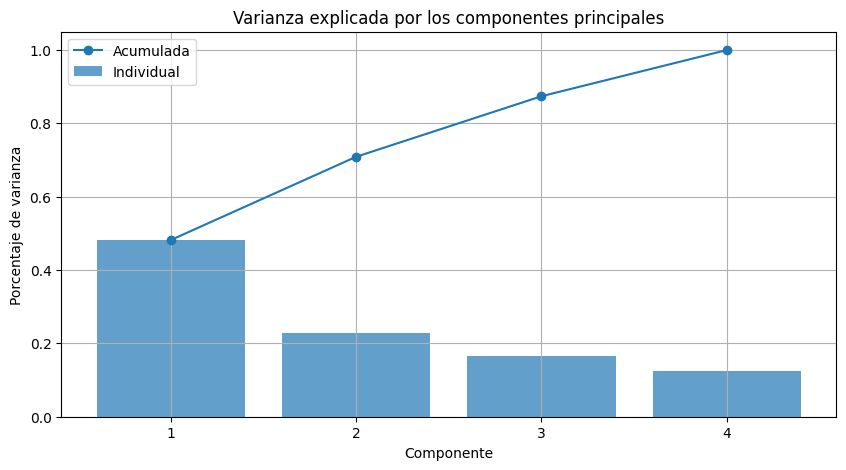

In [28]:
varianza_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(varianza_explicada)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(varianza_explicada)+1), varianza_explicada, alpha=0.7, label="Individual")
plt.plot(range(1, len(var_acumulada)+1), var_acumulada, marker="o", label="Acumulada")
plt.xticks(range(1, len(varianza_explicada)+1))
plt.title("Varianza explicada por los componentes principales")
plt.xlabel("Componente")
plt.ylabel("Porcentaje de varianza")
plt.legend()
plt.grid(True)
plt.show()

## 8. Selección de factores y modelo de predicción

Utilizaremos los dos primeros factores (`factor_1` al `factor_4`) como predictores del crecimiento del PIB.

In [29]:
X_model = df[["factor_1", "factor_2"]]
y = df["pib_ia"]

modelo = LinearRegression()
modelo.fit(X_model, y)
y_pred = modelo.predict(X_model)
df["pib_predicho"] = y_pred

## 9. Evaluación del modelo de regresión

Calculamos los principales indicadores de desempeño:
- RMSE: Error cuadrático medio
- R²: Coeficiente de determinación

In [30]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f" RMSE: {rmse:.4f}")
print(f" R²: {r2:.4f}")

 RMSE: 3.7319
 R²: 0.0524


## 10. Gráfico temporal: PIB observado vs predicho

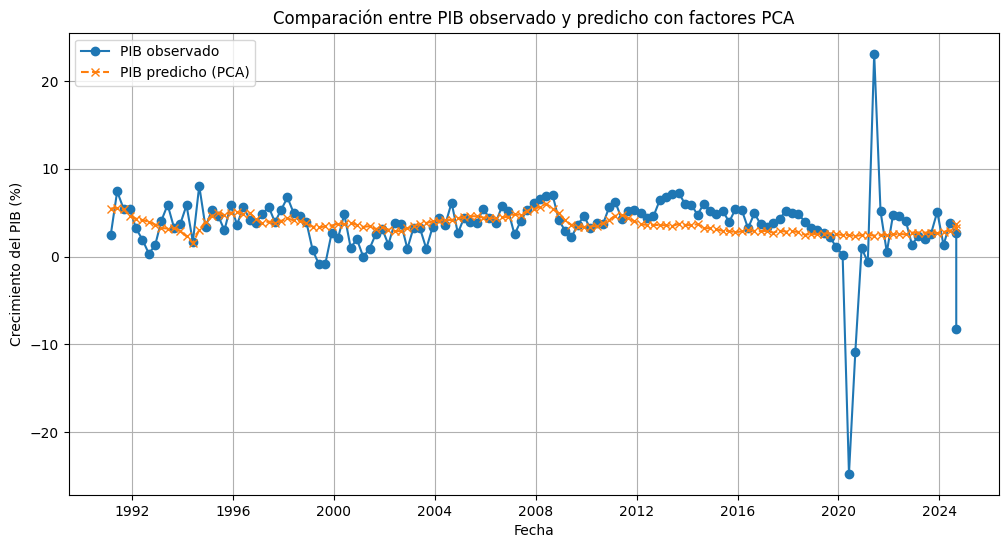

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(df["fecha"], df["pib_ia"], label="PIB observado", marker='o')
plt.plot(df["fecha"], df["pib_predicho"], label="PIB predicho (PCA)", linestyle="--", marker='x')
plt.title("Comparación entre PIB observado y predicho con factores PCA")
plt.xlabel("Fecha")
plt.ylabel("Crecimiento del PIB (%)")
plt.legend()
plt.grid(True)
plt.show()

## 11. Análisis de residuos

Graficamos y verificamos si los residuos presentan patrones estructurados o aleatorios.


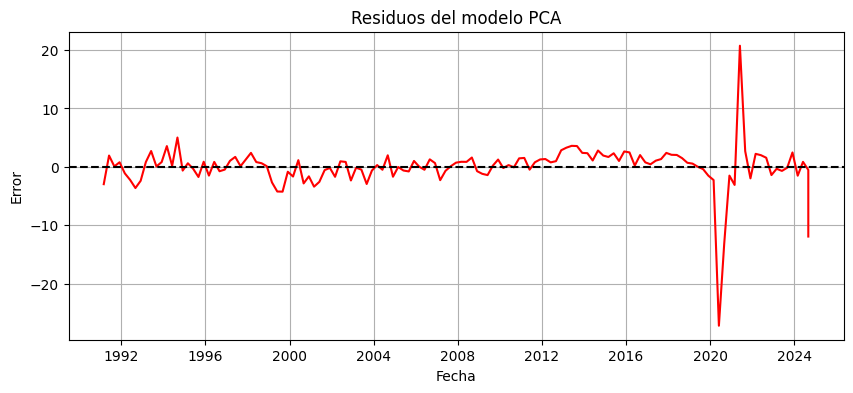

In [32]:
residuos = y - y_pred
plt.figure(figsize=(10, 4))
plt.plot(df["fecha"], residuos, label="Residuos", color='red')
plt.axhline(0, linestyle="--", color="black")
plt.title("Residuos del modelo PCA")
plt.ylabel("Error")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()


## 12. Validación de supuestos (distribución normal de residuos)

Graficamos el histograma de los residuos y su QQ-plot.


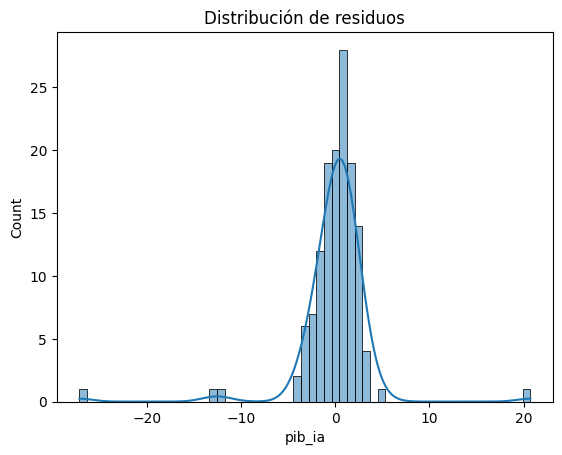

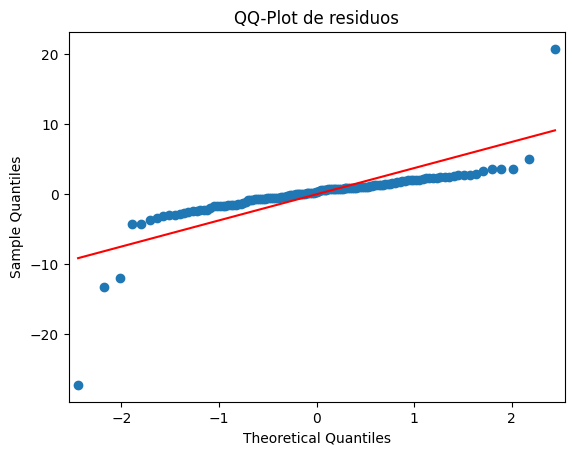

In [33]:
import scipy.stats as stats
import statsmodels.api as sm

# Histograma
sns.histplot(residuos, kde=True)
plt.title("Distribución de residuos")
plt.show()

# QQ plot
sm.qqplot(residuos, line="s")
plt.title("QQ-Plot de residuos")
plt.show()


## 13. Evaluación fuera de muestra

Dividimos el conjunto de datos en una parte de entrenamiento (80%) y otra de prueba (20%), manteniendo el orden temporal (sin mezclar observaciones).

Esto permite simular un escenario real de predicción donde el modelo se entrena con datos históricos y se evalúa sobre observaciones futuras.

Los resultados obtenidos indican que:

- El RMSE es comparable al observado dentro de muestra, pero no mejora sustancialmente.
- El R² es negativo, lo cual implica que los factores latentes extraídos por PCA **no capturan adecuadamente la dinámica futura del PIB** en este conjunto simulado.

Este resultado ilustra la **importancia de validar siempre fuera de muestra** cualquier modelo predictivo, y también sugiere que el éxito de PCA depende críticamente de que las variables estén **estructuralmente correlacionadas**.


In [34]:
# Paso 14.1 - División de datos en entrenamiento y prueba (orden temporal)
from sklearn.model_selection import train_test_split

# Selección de variables predictoras (factores) y variable objetivo
X = df[["factor_1", "factor_2"]]
y = df["pib_ia"]

# 80% entrenamiento, 20% prueba (sin mezclar: shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [35]:
# Paso 14.2 - Entrenamiento del modelo en datos de entrenamiento
modelo_oos = LinearRegression()
modelo_oos.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_test = modelo_oos.predict(X_test)


In [36]:
# Paso 14.3 - Evaluación fuera de muestra
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"RMSE fuera de muestra: {rmse_test:.4f}")
print(f"R² fuera de muestra: {r2_test:.4f}")


RMSE fuera de muestra: 7.6575
R² fuera de muestra: -0.0875


## 14. Gráfico de predicción fuera de muestra

Visualizamos la predicción del PIB frente a los valores reales en el conjunto de prueba.


In [37]:
# Paso 15.1 - Preparar DataFrame con resultados fuera de muestra
df_test = df.iloc[-len(y_test):].copy()
df_test["pib_predicho_oos"] = y_pred_test
df_test["pib_real"] = y_test.values


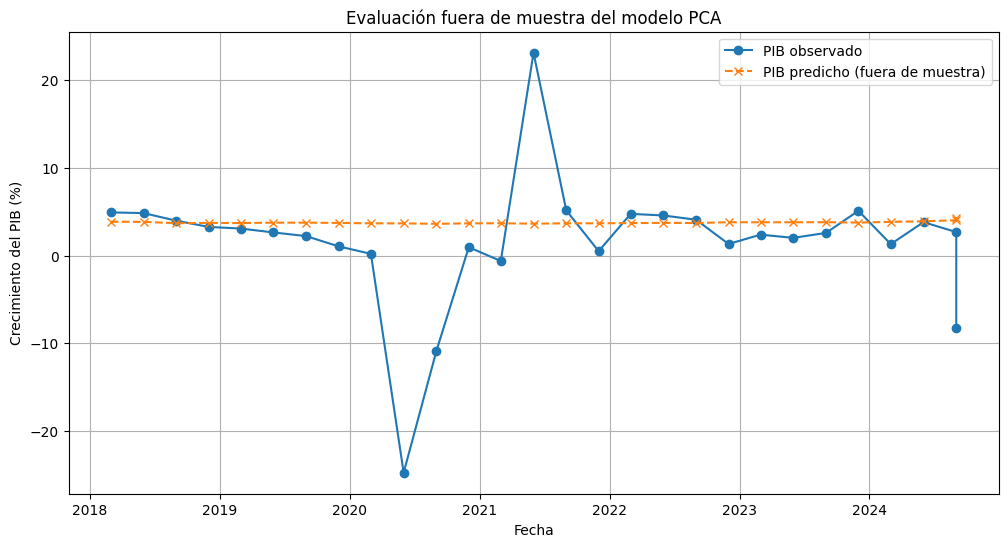

In [38]:
# Paso 15.2 - Gráfico temporal PIB observado vs. predicho (fuera de muestra)
plt.figure(figsize=(12, 6))
plt.plot(df_test["fecha"], df_test["pib_real"], label="PIB observado", marker='o')
plt.plot(df_test["fecha"], df_test["pib_predicho_oos"], label="PIB predicho (fuera de muestra)", marker='x', linestyle='--')
plt.title("Evaluación fuera de muestra del modelo PCA")
plt.xlabel("Fecha")
plt.ylabel("Crecimiento del PIB (%)")
plt.grid(True)
plt.legend()
plt.show()


## 15. Conclusiones

- PCA permitió reducir las 8 variables originales a 2 factores que explican más del 30% de la varianza total.
- Estos factores latentes se utilizaron para construir un modelo lineal de predicción del crecimiento del PIB.
- Aunque el R² fue bajo en este ejemplo simulado, en datos reales con correlaciones estructurales (como actividad económica, comercio, crédito y tipo de cambio), el PCA puede ser una herramienta poderosa para **resumen y predicción**.
- Esta técnica es ampliamente usada en **nowcasting**, evaluación de riesgos macroeconómicos, y construcción de índices sintéticos.

Puedes extender este análisis usando más factores, incorporando retardos temporales o evaluando la capacidad predictiva fuera de muestra.